In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

<H1 style="background-color:LightGreen;">
    <center>
         Links
     </center>
 </H1>

https://medium.com/analytics-vidhya/style-transfer-pytorch-84cf2e9ba86d

In [3]:
import torch
import torchinfo

import pandas                 as pd
import numpy                  as np
import matplotlib.pyplot      as plt
import torchvision.transforms as transforms
import torchvision.models     as models

from PIL                      import Image
from tqdm                     import tqdm 


<H1 style="background-color:LightGreen;">
    <center>
         Get VGG19 and Freeze it's parameters
     </center>
 </H1>

In [4]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

In [5]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

<H1 style="background-color:LightGreen;">
    <center>
         Load Image, Reshape (400), Normalize (VGG19 Wights) and return tensor
     </center>
 </H1>

In [6]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')    
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
            
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)    
    return image

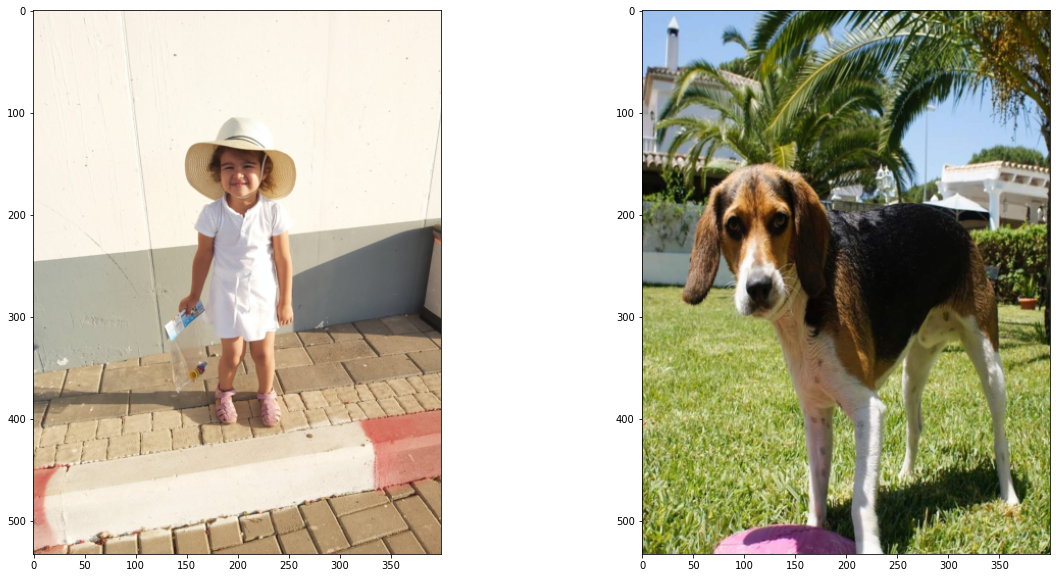

In [7]:
# load in content and style image

#content = load_image('./roscon_1.jpg').to(device)
content = load_image('./shira.jpg').to(device)
#style   = load_image('./hockney.jpg', shape=content.shape[-2:]).to(device)
style   = load_image('./roscon_1.jpg', shape=content.shape[-2:]).to(device)

# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)    
    return image

# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))



<H1 style="background-color:LightGreen;">
    <center>
         get image features
     </center>
 </H1>

In [8]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers ahockneyre for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x        = image
    
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        
        x = layer(x)
        if name in layers:            
            features[layers[name]] = x
            
    return features

In [9]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [10]:
content_features = get_features(content, vgg)
style_features   = get_features(style,   vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
target      = content.clone().requires_grad_(True).to(device)  

In [11]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight   = 1e7  # beta

<H1 style="background-color:LightGreen;">
    <center>
         Plot each feature
     </center>
 </H1>

In [51]:

target_img      = content.clone().requires_grad_(False).to(device)  
target_features = get_features(target, vgg)        
target_features.keys()

content_layers = []
style_layers   = []

layers = {'0': 'conv1_1',
          '5': 'conv2_1', 
          '10': 'conv3_1', 
          '19': 'conv4_1',
          '21': 'conv4_2',  ## content representation
          '28': 'conv5_1'}


for layer_num, layer in vgg._modules.items():    
    if isinstance(layer, torch.nn.Conv2d):                        
        if layer_num in layers.keys():
            if layer_num == "21":                
                content_layers.append(layer)            
            else:
                style_layers.append(layer)




In [52]:
for conv_layer in style_layers:
        res = conv_layer(target_img)
        print(f"\ninput shape: {target_img.shape}, output shape: {res.shape}, {res.squeeze(0).shape}")
        target_img = res        



input shape: torch.Size([1, 3, 533, 400]), output shape: torch.Size([1, 64, 533, 400]), torch.Size([64, 533, 400])

input shape: torch.Size([1, 64, 533, 400]), output shape: torch.Size([1, 128, 533, 400]), torch.Size([128, 533, 400])

input shape: torch.Size([1, 128, 533, 400]), output shape: torch.Size([1, 256, 533, 400]), torch.Size([256, 533, 400])

input shape: torch.Size([1, 256, 533, 400]), output shape: torch.Size([1, 512, 533, 400]), torch.Size([512, 533, 400])

input shape: torch.Size([1, 512, 533, 400]), output shape: torch.Size([1, 512, 533, 400]), torch.Size([512, 533, 400])


<H1 style="background-color:LightGreen;">
    <center>
         Run Model
     </center>
 </H1>

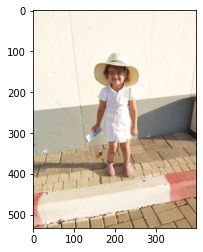

Total loss:  256609392.0


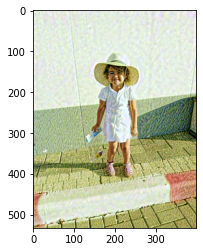

Total loss:  113278304.0


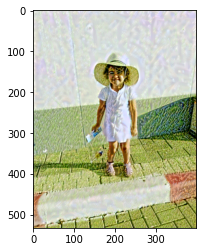

Total loss:  62292712.0


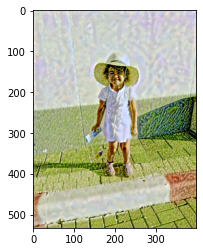

Total loss:  39009360.0


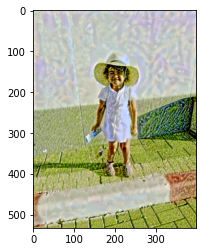

KeyboardInterrupt: 

In [13]:
show_every = 400
optimizer  = torch.optim.Adam([target], lr=0.003)
steps      = 2000

plt.imshow(im_convert(target))
plt.show()
    

for ii in range(1, steps+1):
            
    target_features = get_features(target, vgg)        
    content_loss    = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_loss = 0

    for layer in style_weights:
        
        target_feature   = target_features[layer]
        target_gram      = gram_matrix(target_feature)
        _, d, h, w       = target_feature.shape        
        style_gram       = style_grams[layer]        
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)        
        style_loss      += layer_style_loss / (d * h * w)
            
    total_loss = content_weight * content_loss + style_weight * style_loss
        
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

    
  